# Micrograd Demo

Quick tour of autograd Value objects and a tiny multilayer perceptron trained on a toy dataset.

## Imports and graph helpers

Load `Value` and `MLP` from the repo and define helper functions to trace/draw the computation graph with graphviz. The small wrapper `v` attaches labels so the diagrams are easier to read.

In [2]:
import sys
from pathlib import Path
from graphviz import Digraph

repo_root = Path().resolve()
if not (repo_root / "micrograd").exists():
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from micrograd.engine import Value
from micrograd.neural_net_layers import MLP

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        label = getattr(n, "label", "")
        dot.node(name=uid, label=f"{{ {label} | data {n.data:.4f} | grad {n.grad:.4f} }}", shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

def v(data, label=""):
    val = Value(data)
    val.label = label
    return val


## Scalar gradient check

Build a tiny expression `L = (a*b + c) * f`, run backprop, and inspect the raw data/gradient values to confirm autodiff on scalars works.

In [3]:
a = v(2.0, "a")
b = v(-3.0, "b")
c = v(10.0, "c")
f = v(-2.0, "f")

d = a * b + c
d.label = "d"
L = d * f
L.label = "L"

L.backward()

{n: {"data": v.data, "grad": v.grad} for n, v in [("a", a), ("b", b), ("c", c), ("f", f), ("d", d), ("L", L)]}


{'a': {'data': 2.0, 'grad': 6.0},
 'b': {'data': -3.0, 'grad': -4.0},
 'c': {'data': 10.0, 'grad': -2.0},
 'f': {'data': -2.0, 'grad': 4.0},
 'd': {'data': 4.0, 'grad': -2.0},
 'L': {'data': -8.0, 'grad': 1.0}}

## Visualize the graph

Render the computation graph for `L` to see how the operations connect.

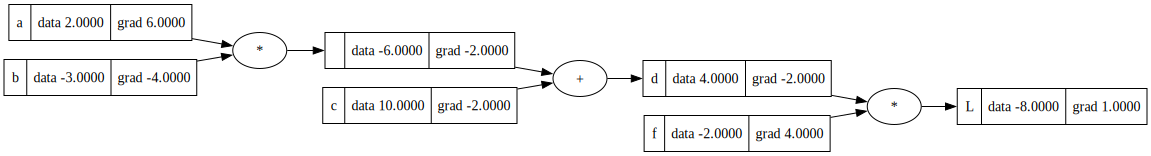

In [4]:
draw_dot(L)


## Train a tiny MLP

Create a 3->4->4->1 network and a toy dataset. `loss_and_preds` computes squared error against the target labels. The loop runs 30 steps of manual gradient descent (lr=0.05) while zeroing grads by hand to mirror what a deep learning library does under the hood.

In [5]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [4, 4, 1])

def loss_and_preds():
    y_pred = [mlp(x)[0] for x in xs]
    losses = []
    for yout, ygt in zip(y_pred, ys):
        diff = yout + Value(-ygt)
        losses.append(diff * diff)
    total_loss = sum(losses, Value(0.0))
    return total_loss, y_pred

for step in range(30):
    loss, y_pred = loss_and_preds()
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()
    lr = 0.05
    for p in mlp.parameters():
        p.data -= lr * p.grad
    if step % 10 == 0 or step == 29:
        print(f"step {step:02d} | loss {loss.data:.4f}")


step 00 | loss 8.4070
step 10 | loss 0.1598
step 20 | loss 0.0546
step 29 | loss 0.0325


## Check predictions

Evaluate the trained model on the training points to see if the predicted signs line up with the desired labels.

In [6]:
loss, preds = loss_and_preds()
for x, pred, target in zip(xs, preds, ys):
    print(f"x={x} -> pred={pred.data:.3f} (target={target})")


x=[2.0, 3.0, -1.0] -> pred=0.926 (target=1.0)
x=[3.0, -1.0, 0.5] -> pred=-0.904 (target=-1.0)
x=[0.5, 1.0, 1.0] -> pred=-0.911 (target=-1.0)
x=[1.0, 1.0, -1.0] -> pred=0.908 (target=1.0)
